In [30]:
# Import necessary libraries
import jax.numpy as jnp
from jax import random, grad, jit, lax
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_gc_localization_matrix
#from jax_filters import ensrf_steps
import jax
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum

# num_steps = 200  # Number of simulation steps
# n = 256 # Dimensionality of the state space for KS model
# observation_interval = 5  # Interval at which observations are made
# dt = 0.25  # Time step for the KS model
# ks_model = KuramotoSivashinsky(dt=dt, s=n, l=22, M=16)
# ks_step = Partial(ks_model.step)

N = 10 # number of Monte Carlo samples
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps
J0 = 0
n = 40   # Number of state variables
key = random.PRNGKey(0)  # Random key for reproducibility
x0 = random.normal(key, (n,))
initial_state  = x0
# Noise covariances
Q = 0.03 * jnp.eye(n)  # Process noise covariance
R = 0.01 * jnp.eye(n)  # Observation noise covariance
# Observation matrix (identity matrix for direct observation of all state variables)
H = jnp.eye(n)

n_ensemble = 10
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state



l96_model = Lorenz96(dt = dt, F = 8)
l96_step = Partial(l96_model.step)
# Generate true states and observations using the Lorenz '96 model

state_transition_function = l96_model.step
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

In [2]:
# plt.plot(true_states[:, 1])
# plt.plot(observations[:, 1])
# observations[:, 1]

In [3]:
@jit
def ensrf_step(ensemble, y, H, Q, R, localization_matrix, inflation, key):
    n_ensemble = ensemble.shape[1]
    x_m = jnp.mean(ensemble, axis=1)
    ensemble += random.multivariate_normal(key, jnp.zeros(ensemble.shape[0]), Q, (n_ensemble,)).T
    A = ensemble - x_m.reshape((-1, 1))
    #A = A*inflation
    Pf = inflation*(A @ A.T) / (n_ensemble - 1)
    P = Pf * localization_matrix  # Element-wise multiplication for localization
    K = P @ H.T @ jnp.linalg.inv(H @ P @ H.T + R)
    x_m += K @ (y - H @ x_m)
    M = jnp.eye(x_m.shape[0]) + P @ H.T @ jnp.linalg.inv(R) @ H
    eigenvalues, eigenvectors = eigh(M)
    inv_sqrt_eigenvalues = 1 / jnp.sqrt(eigenvalues)
    Lambda_inv_sqrt = jnp.diag(inv_sqrt_eigenvalues)
    M_inv_sqrt = eigenvectors @ Lambda_inv_sqrt @ eigenvectors.T
    updated_ensemble = x_m.reshape((-1, 1)) + M_inv_sqrt @ A
    updated_A = updated_ensemble - jnp.mean(updated_ensemble, axis=1).reshape((-1, 1))
    updated_P = localization_matrix*(updated_A @ updated_A.T / (n_ensemble - 1))
    return updated_ensemble, updated_P + jnp.eye(x_m.shape[0])*1e-5  # Now also returning P


@jit
def ensrf_steps(model, n_ensemble, ensemble_init, observations, H, Q, R, localization_matrix, inflation, key):
    """
    Deterministic Ensemble Square Root Filter generalized for any model.
    """
    model_vmap = jax.vmap(lambda v: model(v), in_axes=1, out_axes=1)
    key, *subkeys = random.split(key, num=num_steps+1)
    subkeys = jnp.array(subkeys)

    def inner(carry, t):
        ensemble, _ = carry
        ensemble_predicted = model_vmap(ensemble)

        # Update ensemble and covariance based on observation availability
        ensemble_updated, Pf_updated = ensrf_step(ensemble_predicted, observations[t, :], H, Q, R, localization_matrix, inflation, subkeys[t])
        
        #lax.cond(
            # t % observation_interval == 0,
            # lambda _: ensrf_step(ensemble_predicted, observations[t, :], H, Q, R, localization_matrix, inflation),
            # lambda _: (ensemble_predicted, covariances[t-1]),  # Use the last updated covariance
            # None)

        return (ensemble_updated, Pf_updated), (ensemble_updated, Pf_updated)

    # Initialize storage for covariance matrices, including one for the initial state
    covariance_init = jnp.zeros((n,n))

    # Perform the scan over timesteps with the initial ensemble and covariances
    _, output = jax.lax.scan(inner, (ensemble_init, covariance_init), jnp.arange(num_steps))

    ensembles, covariances = output

    return ensembles, covariances

In [4]:
# localization_matrix = np.ones((n, n))#generate_gc_localization_matrix(n, 5)
# ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
# e, c = ensrf_steps(l96_step, n_ensemble, ensemble_init, observations, H, Q, R, localization_matrix, 1.0, key)
# plt.plot(e.mean(axis=(1,2)))
# plt.plot(true_states.mean(axis=1))
# #plt.plot([np.trace(cc) for cc in c])

In [5]:
# plt.pcolormesh(c[-1])
# plt.colorbar()

In [22]:
@jit
def var_cost(radius, inflation, model, ensemble_init, observations, H, Q, R, key, J, J0):
    localization_matrix = generate_gc_localization_matrix(n, radius)
    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, observations, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean, covariances, n, model, Q, key, N)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, J, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.mean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    print(cost)
    return cost

In [33]:
import properscoring
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random


# Modification: Use grad to compute the gradient with respect to the radius parameter
var_cost_grad = grad(var_cost, argnums=0)

inflation = 1.2  # Example starting value for inflation
radius_opt = 4.0
alpha = 1e-5  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
radii = []
rmses=[]

for i in tqdm(range(50)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_radius = var_cost_grad(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    print(grad_radius)
    radius_opt -= alpha * grad_radius  # Update inflation parameter
    radii.append(radius_opt)
    localization_matrix = generate_gc_localization_matrix(n, radius_opt)

    states, _ = ensrf_steps(l96_step, n_ensemble, ensemble_init, observations, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    #clear_output(wait=True)
    
    print(radius_opt, crps)

  0%|          | 0/50 [00:00<?, ?it/s]

1293.268
3.9870672 0.14562095515742687
1347.2727
3.9735944 0.14535744561598798
1359.2587
3.960002 0.14397415404659325
1405.6039
3.945946 0.14590003641390445
1242.1554
3.9335244 0.14595278133806328
1232.842
3.921196 0.14488485462993936
1291.0123
3.9082859 0.14529604084055944
1310.6969
3.8951788 0.14571759209709698
1382.5071
3.8813536 0.14606828366467214
1284.1265
3.8685124 0.14528589593260943
1219.236
3.8563201 0.1445402169028544
1222.0923
3.8440993 0.14538012709838433
1193.0233
3.832169 0.14565789072208593
1306.925
3.8191 0.1447594439690573
1397.1675
3.8051283 0.14480269198262855
1165.26
3.7934756 0.14632272603313298
1074.2178
3.7827334 0.14497390256392106
1243.6299
3.770297 0.14523142682643536
1071.3317
3.7595837 0.1446349013765452
1212.7441
3.7474563 0.14524496776928025
1066.4453
3.7367918 0.1453648037528462
1172.7727
3.725064 0.14636077376595907
1158.3086
3.713481 0.1459278490755778
1154.3247
3.7019377 0.14565768930888606
nan
nan 1.9246636912533013
nan
nan 1.97899022847618
nan
nan 1

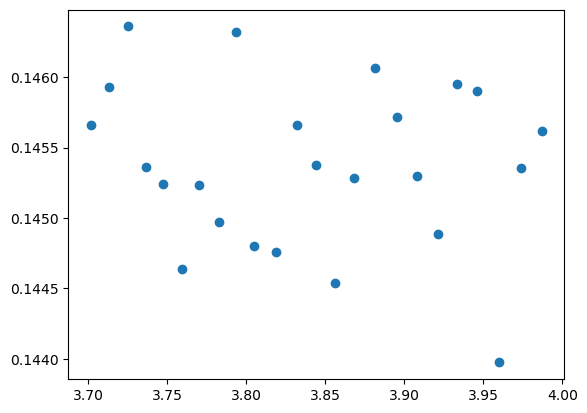

In [34]:
plt.scatter(radii, crpss)

In [35]:
plt.scatter(radii, rmses)

NameError: name 'rmses' is not defined